In [1]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from skimage import transform
from scipy import ndimage
from matplotlib import pyplot as plt
import tensorflow as tf

import util
reload(util);

import image_aug
reload(image_aug);

import luna_cropper;
reload(luna_cropper);

import luna_preprocess
reload(luna_preprocess);

import luna_unet_data
reload(luna_unet_data);

import luna_train_unet
reload(luna_train_unet);

import luna_unet_data2
reload(luna_unet_data2);

import luna_train_unet2
reload(luna_train_unet2);

Using TensorFlow backend.


In [157]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

In [169]:
x = annt_df.groupby('file').count()
x = list(x[x.seriesuid>5].index)
f = x[np.random.randint(len(x))]
f_id = luna_preprocess.get_file_id(f)
print f_id
annt_df[annt_df.file==f]

1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224169985110295082004


,seriesuid,coordX,coordY,coordZ,diameter_mm,file
372,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,105.092748,-12.110345,-163.856396,6.675664,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
373,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,-65.241881,-2.009534,-154.598809,5.611382,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
374,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,95.503262,50.833093,-98.177352,9.697334,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
375,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,-44.350818,-2.878997,-80.206244,6.734931,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
376,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,-36.792992,30.768708,-78.630046,7.213573,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
377,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,114.181220,39.588505,-77.015513,6.554327,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
378,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,101.203838,25.220465,-133.813245,6.269450,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
379,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,99.758466,42.833697,-142.790683,6.392033,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...
380,1.3.6.1.4.1.14519.5.2.1.6279.6001.195557219224...,76.624649,-2.190466,-170.154161,5.512270,../LUNA16/subset9/1.3.6.1.4.1.14519.5.2.1.6279...


In [170]:
image = luna_preprocess.Image()
image.load(f_id)

In [171]:
masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()
print len(nodules)

9


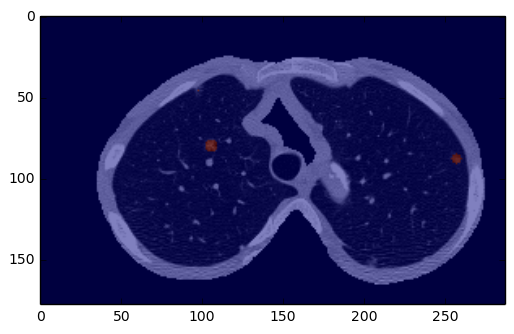

In [221]:
nod_idx = 5
slice_z = nodules[nod_idx][2]
new_image = masked_lung[slice_z]
new_image = util.normalize(new_image, 0.0)
new_nodule_mask = all_nodule_mask[slice_z]
plt.imshow(new_image, cmap='gray')
plt.imshow(new_nodule_mask, cmap='jet', alpha=0.5)

In [234]:
_SEED = 123456
image_aug = luna_unet_data2._make_aug(_SEED)
mask_aug = luna_unet_data2._make_aug(_SEED)

debug:  1
debug:  0
debug:  1
debug:  1
debug:  0
debug:  1
debug:  1
debug:  1
debug:  0
debug:  0


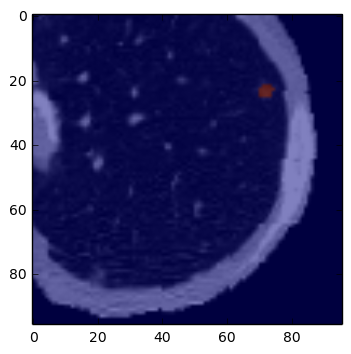

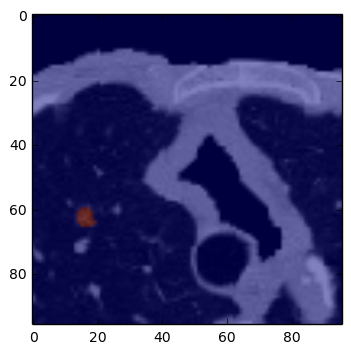

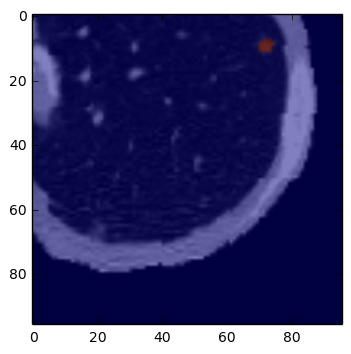

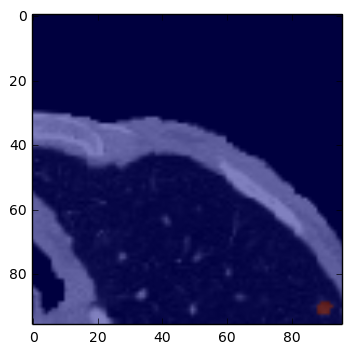

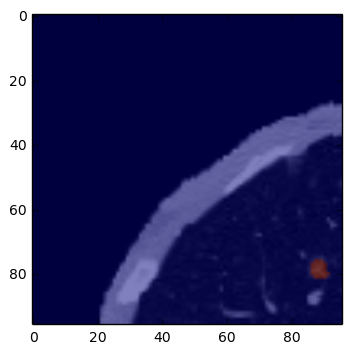

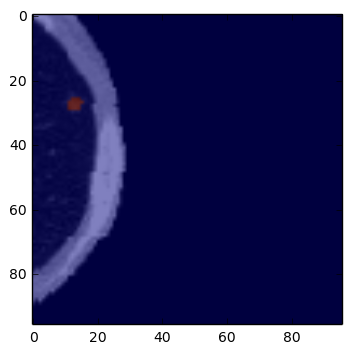

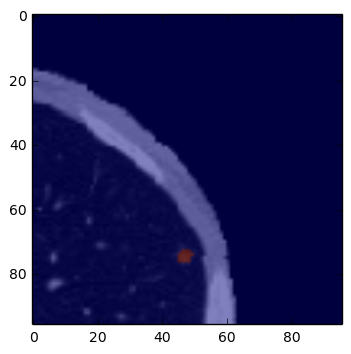

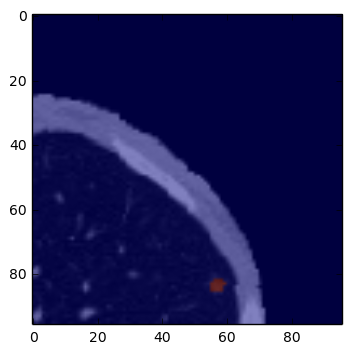

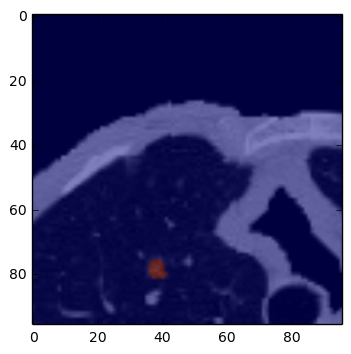

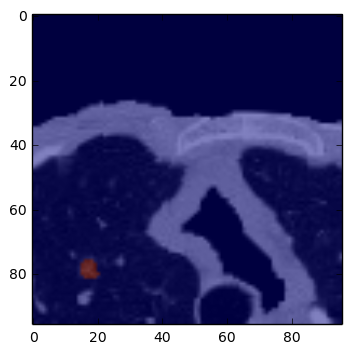

In [235]:
pos_ans, neg_ans = luna_unet_data2._sample_patches(
    new_image, new_nodule_mask, image_aug, mask_aug)
for t_image, t_nodule_mask in pos_ans:
    plt.figure()
    plt.imshow(t_image, cmap='gray')
    plt.imshow(t_nodule_mask, cmap='jet', alpha=0.5)
    plt.show()
#print '='*80
#for t_image, t_nodule_mask in neg_ans:
#    plt.figure()
#    plt.imshow(t_image, cmap='gray')
#    plt.imshow(t_nodule_mask, cmap='jet', alpha=0.5)
#    plt.show()

In [2]:
def pred_nodule_mask(image, model):
    ans = np.zeros_like(image)
    for i in range(5):
        for j in range(5):
            row_slice = slice(i * 96, (i + 1) * 96)
            col_slice = slice(j * 96, (j + 1) * 96)
            image_patch = np.reshape(image[row_slice, col_slice], [1, 1, 96, 96])
            image_patch = luna_train_unet2.normalize_images(image_patch)
            mask_patch = model.predict(image_patch)[0,0]
            ans[row_slice, col_slice] = mask_patch
    return ans

In [3]:
with tf.device('/cpu:0'):
    model = luna_train_unet2.get_unet()

In [4]:
model.load_weights('./unet2.hdf5')

In [5]:
images, nodule_masks = luna_unet_data.load_data(['subset9'])

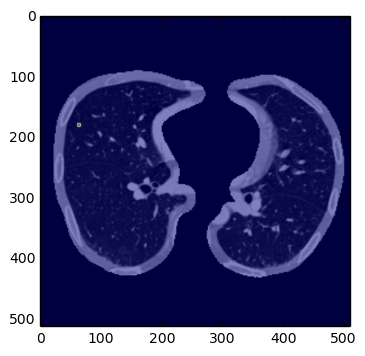

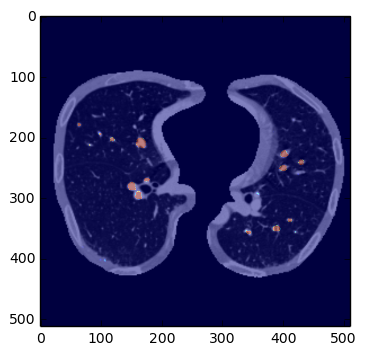

In [6]:
idx = np.random.randint(len(images))
image = images[idx][0]
nodule_mask = nodule_masks[idx][0]
test_nodule_mask = pred_nodule_mask(image, model)
plt.figure()
plt.imshow(image, cmap='gray')
plt.imshow(nodule_mask, cmap='jet', alpha=0.5)
plt.figure()
plt.imshow(image, cmap='gray')
plt.imshow(test_nodule_mask, cmap='jet', alpha=0.5)

In [13]:
data_dirs = sorted(glob(luna_preprocess._DATA_DIR))
data_dir = data_dirs[0]
file_list = glob(os.path.join(data_dir, '*.mhd'))
f = file_list[np.random.randint(len(file_list))]
f_id = luna_preprocess.get_file_id(f)
print f_id

image = luna_preprocess.Image()
image.load(f_id)

masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()

1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321


0.00521095153738


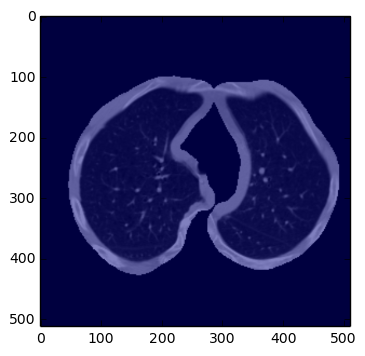

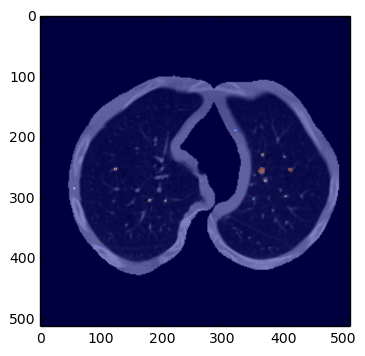

In [14]:
new_image, new_nodule_mask = luna_unet_data.slice_image(
    masked_lung, all_nodule_mask, np.random.randint(len(masked_lung)))
test_nodule_mask = pred_nodule_mask(new_image, model)

print luna_train_unet2.dice_coef_np(new_nodule_mask, test_nodule_mask)

plt.figure()
plt.imshow(new_image, cmap='gray')
plt.imshow(new_nodule_mask, cmap='jet', alpha=0.5)
plt.figure()
plt.imshow(new_image, cmap='gray')
plt.imshow(test_nodule_mask, cmap='jet', alpha=0.5)

In [419]:
imgs_train, imgs_mask_train = luna_train_unet2.load_data(
    ['subset9'])

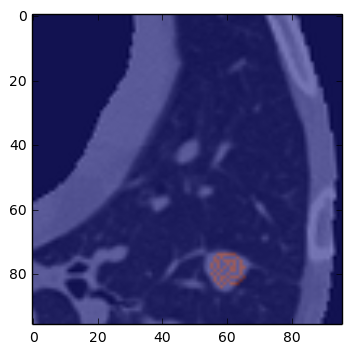

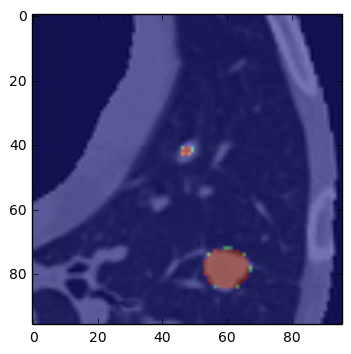

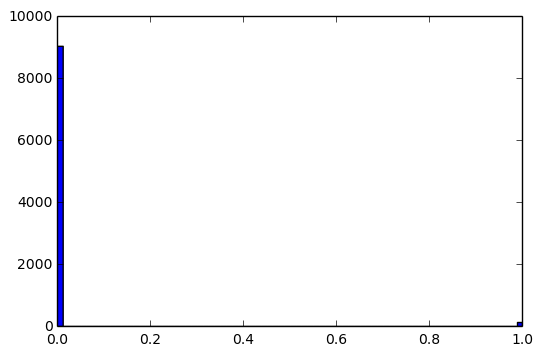

In [551]:
idx = np.random.randint(len(imgs_train))
test_mask = model.predict(imgs_train[idx:idx+1])

plt.figure()
plt.imshow(imgs_train[idx][0], cmap='gray')
plt.imshow(imgs_mask_train[idx][0], cmap='jet', alpha=0.5)
plt.show()

plt.figure()
plt.imshow(imgs_train[idx][0], cmap='gray')
plt.imshow(test_mask[0][0], cmap='jet', alpha=0.5)
plt.show()
plt.figure()
plt.hist(test_mask[0][0].flatten(), bins=80);

In [691]:
import util
reload(util);

import image_aug
reload(image_aug);

import luna_cropper
reload(luna_cropper);

import luna_preprocess
reload(luna_preprocess);

_SEED = 123456789
_CROP_HEIGHT = 96
_CROP_WIDTH = 96
_NUM_PATCHES = 10

In [692]:
image_aug = luna_unet_data2._make_aug(_SEED)
mask_aug = luna_unet_data2._make_aug(_SEED)

In [635]:
data_dirs = sorted(glob(luna_preprocess._DATA_DIR))

In [636]:
file_list = glob(os.path.join(data_dirs[9], '*.mhd'))

In [694]:
f_id = luna_preprocess.get_file_id(
    file_list[np.random.randint(len(file_list))])
print f_id
image = luna_preprocess.Image()
image.load(f_id)
masked_lung = image.masked_lung
nodule_masks = image._nodule_masks
nodules = image.get_v_nodules()

nod_idx = np.random.randint(len(nodules))
nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodules[nod_idx]
nodule_mask = nodule_masks[nod_idx]
slice_z = nod_v_z

new_image = masked_lung[slice_z]
new_image = util.normalize(new_image, 0.0)
new_image1, new_image1_trace = image_aug.apply(new_image, True)

new_nodule_mask = nodule_mask[slice_z]
new_nodule_mask1, new_nodule_mask1_trace = mask_aug.apply(new_nodule_mask, True)
print len(new_nodule_mask1_trace)

1.3.6.1.4.1.14519.5.2.1.6279.6001.174449669706458092793093760291
[True, False]
[True, False]
2


In [690]:
[bool(int(x)) for x in bin(a)[2:]]

[True, False, True]

In [687]:
a = int(image_aug._rand(1, 2**3))
print a
[bool(int(x)) for x in bin(a)[2:]]

5


[True, True, True]

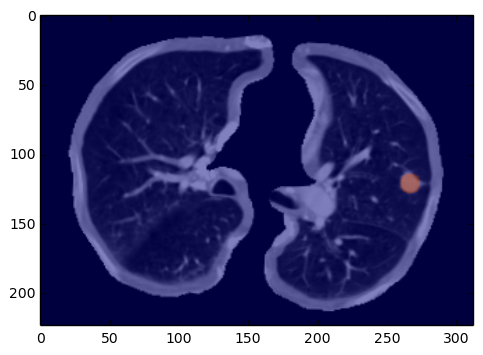

In [695]:
plt.imshow(new_image1, cmap='gray')
plt.imshow(new_nodule_mask1, cmap='jet', alpha=0.5)

In [650]:
new_nodule_mask1_trace

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], dtype=bool),
 (0, 8.000680259864485, array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ..., 
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]], dtype=bool)),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, Fal

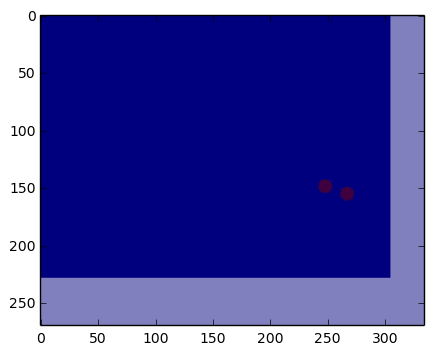

In [632]:
x = new_nodule_mask1_trace[0]
plt.imshow(x, cmap='jet')
x = ndimage.rotate(x, angle=8.2, order=0, mode='constant', cval=0, reshape=True)
plt.imshow(x, cmap='jet', alpha=0.5)